In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Descargar información de Ecobici para crear gráficas de uso por género.
Correr esto sólo una vez pues puede ser tardado.
Los resultados se encuentran en pesos y géneros

In [123]:
dates = pd.date_range(start='01-01-2017',periods= 18,freq='m').astype(str)
dates = dates.map(lambda x: x[:7])

In [124]:
##Templates
pesos = pd.DataFrame()
generos = pd.DataFrame(index = {'M','F'})

In [125]:
for d in dates:
    url = 'https://www.ecobici.cdmx.gob.mx/sites/default/files/data/usages/'+d+'.csv'
    data = pd.read_csv(url)
    gen = pd.DataFrame( {d : data['Genero_Usuario'].value_counts() } )
    generos = pd.concat([generos,gen],axis = 1)
    data[d]=1
    pes = data.pivot_table(values=d,index=['Ciclo_Estacion_Retiro','Ciclo_Estacion_Arribo'],aggfunc=sum)
    pesos = pd.concat([pesos,pes],axis=1)

C:\Users\Scastaneda01\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [126]:
generos = generos.transpose()
pesos.to_csv('pesos.csv')
generos.to_csv('generos.csv')

In [197]:
generos['total'] = generos.sum(axis=1)

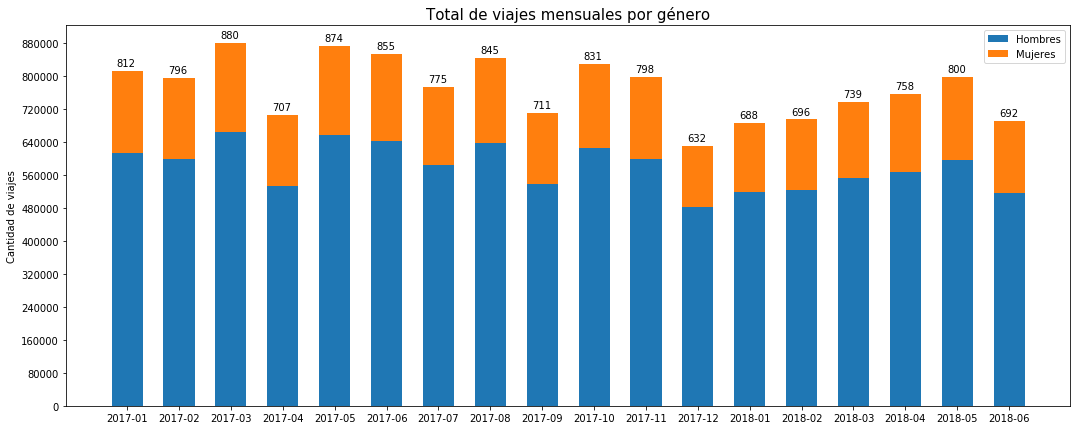

In [216]:
N = generos.shape[0]
ind = np.arange(N)
width = 0.6
plt.figure(figsize=(18,7))
p1 = plt.bar(ind, generos['M'], width)
p2 =plt.bar(ind, generos['F'], width,
             bottom=generos['M'])
for t in ind:
    plt.annotate(str( int( round(generos['total'][t]/1000,0) ) ),xy=(ind[t]-0.2,generos['total'][t]+10000))

plt.ylabel('Cantidad de viajes')
plt.title('Total de viajes mensuales por género',size=15)
plt.xticks(ind, (generos.index))
plt.yticks(np.arange(0, 960000, 80000))
plt.legend((p1[0], p2[0]), ('Hombres', 'Mujeres'))


### Redes

In [212]:
import numpy as np
import networkx as nx

In [213]:
pesos = pd.read_csv('pesos.csv',dtype={'Ciclo_Estacion_Retiro':str,'Ciclo_Estacion_Arribo':str,'prom':float})
pesos_2017 = pesos.iloc[:,:14]
pesos_2017['prom']= np.round(pesos_2017.iloc[:,2:].fillna(0).mean(axis=1))
pesos_2017 = pesos_2017[['Ciclo_Estacion_Retiro','Ciclo_Estacion_Arribo','prom']]

In [214]:
pesos_2017.head(3)

Ciclo_Estacion_Retiro Ciclo_Estacion_Arribo   prom
0                     1                     1  156.0
1                     1                     2   69.0
2                     1                     3   56.0

In [215]:
pesos_2017.sort_values('prom',ascending=False).head()

Ciclo_Estacion_Retiro Ciclo_Estacion_Arribo   prom
89562                   211                   217  521.0
7392                     18                     1  492.0
17                        1                    18  368.0
91923                   217                   211  344.0
37388                    85                   174  331.0

In [216]:
eco = pd.read_csv('data/Locations.csv',dtype={'id':str,'lat':float,'lon':float})
eco['lat'] = eco['lat'].round(5)
eco['lon'] = eco['lon'].round(5)
eco.head()
# Mantenemos únicamente registros con viajes promedio mayores a 20
pesos_2017
pes2 = pesos_2017.query('prom>20')
## Creamos una lista con las latitudes y longitudes de cada ciclo
pos = [(np.round(eco.loc[n][1],decimals=5),eco.loc[n][2]) for n in range(eco.shape[0])]

### Creamos lista de edges y agregamos atributos a los nodos

In [217]:
G = nx.from_pandas_dataframe(pes2,'Ciclo_Estacion_Retiro','Ciclo_Estacion_Arribo',edge_attr='prom',create_using=nx.DiGraph())
for node,position in zip(G.nodes,pos):
    G.node[node]['pos']=position

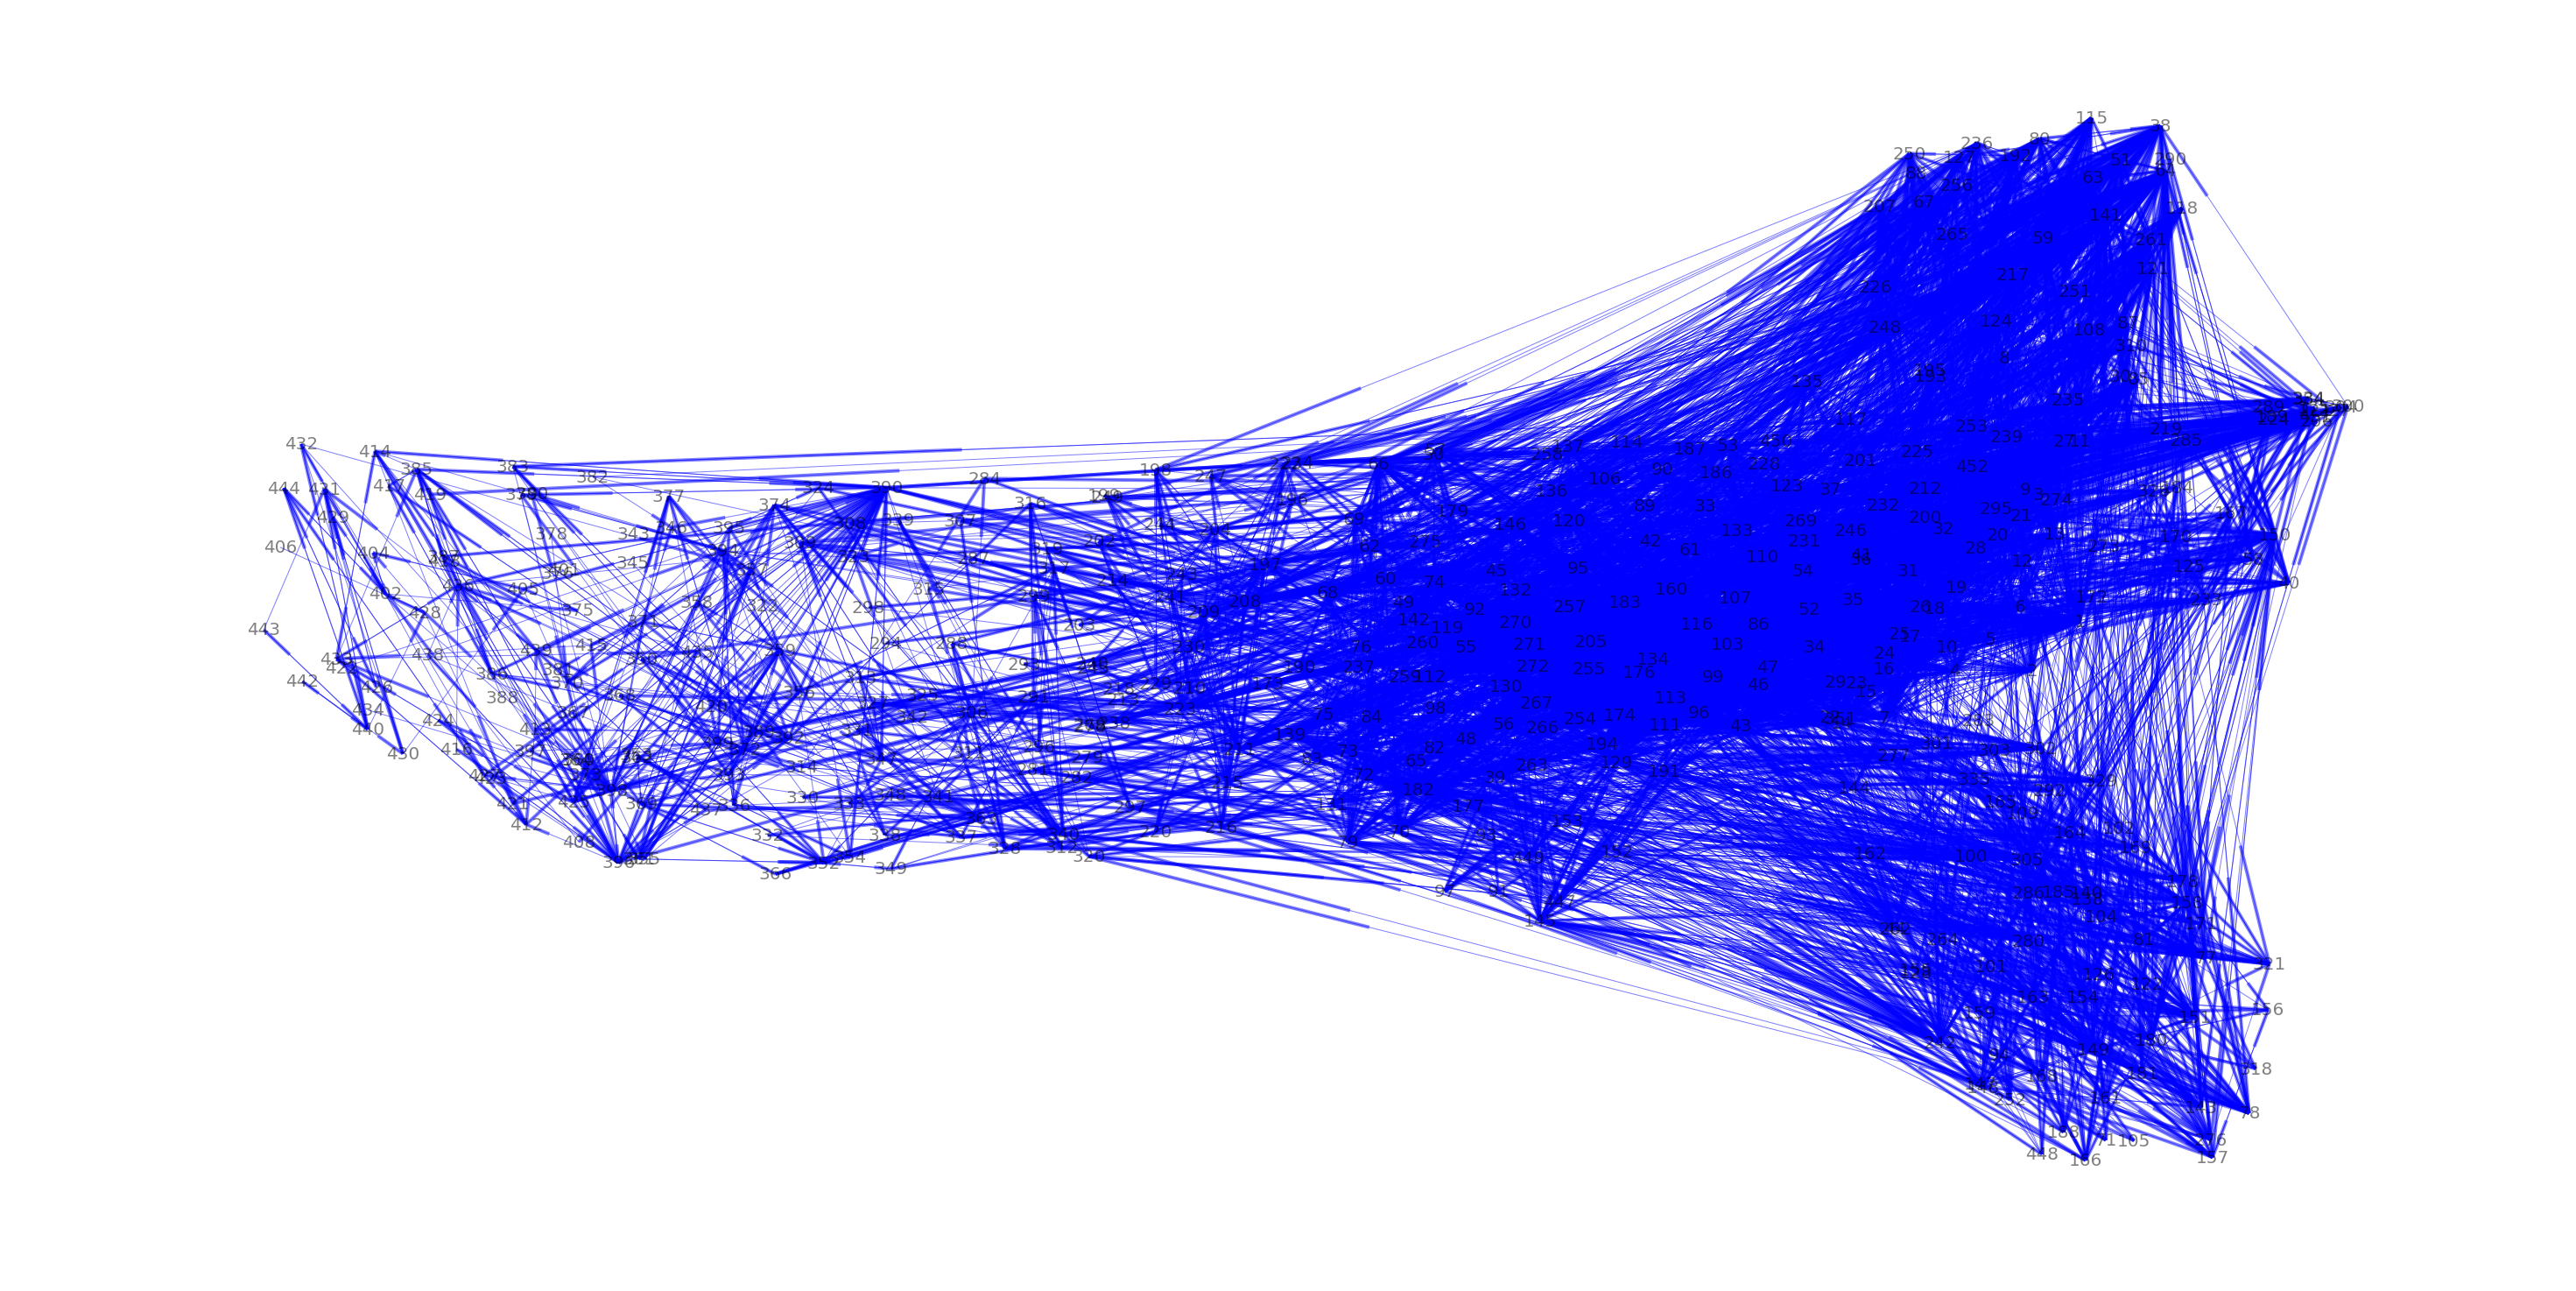

In [219]:
plt.figure(figsize=(40,20))
nx.draw(G,nx.get_node_attributes(G,'pos'),with_labels=True,node_size=0,edge_color='blue',alpha=.5,font_size=20)


In [220]:
smalls = [(u, v) for (u, v, d) in G.edges(data=True) if d['prom'] < 40]
mediums = [(u, v) for (u, v, d) in G.edges(data=True) if (d['prom'] >= 40 and d['prom'] < 100)]
larges = [(u, v) for (u, v, d) in G.edges(data=True) if d['prom'] >= 100]

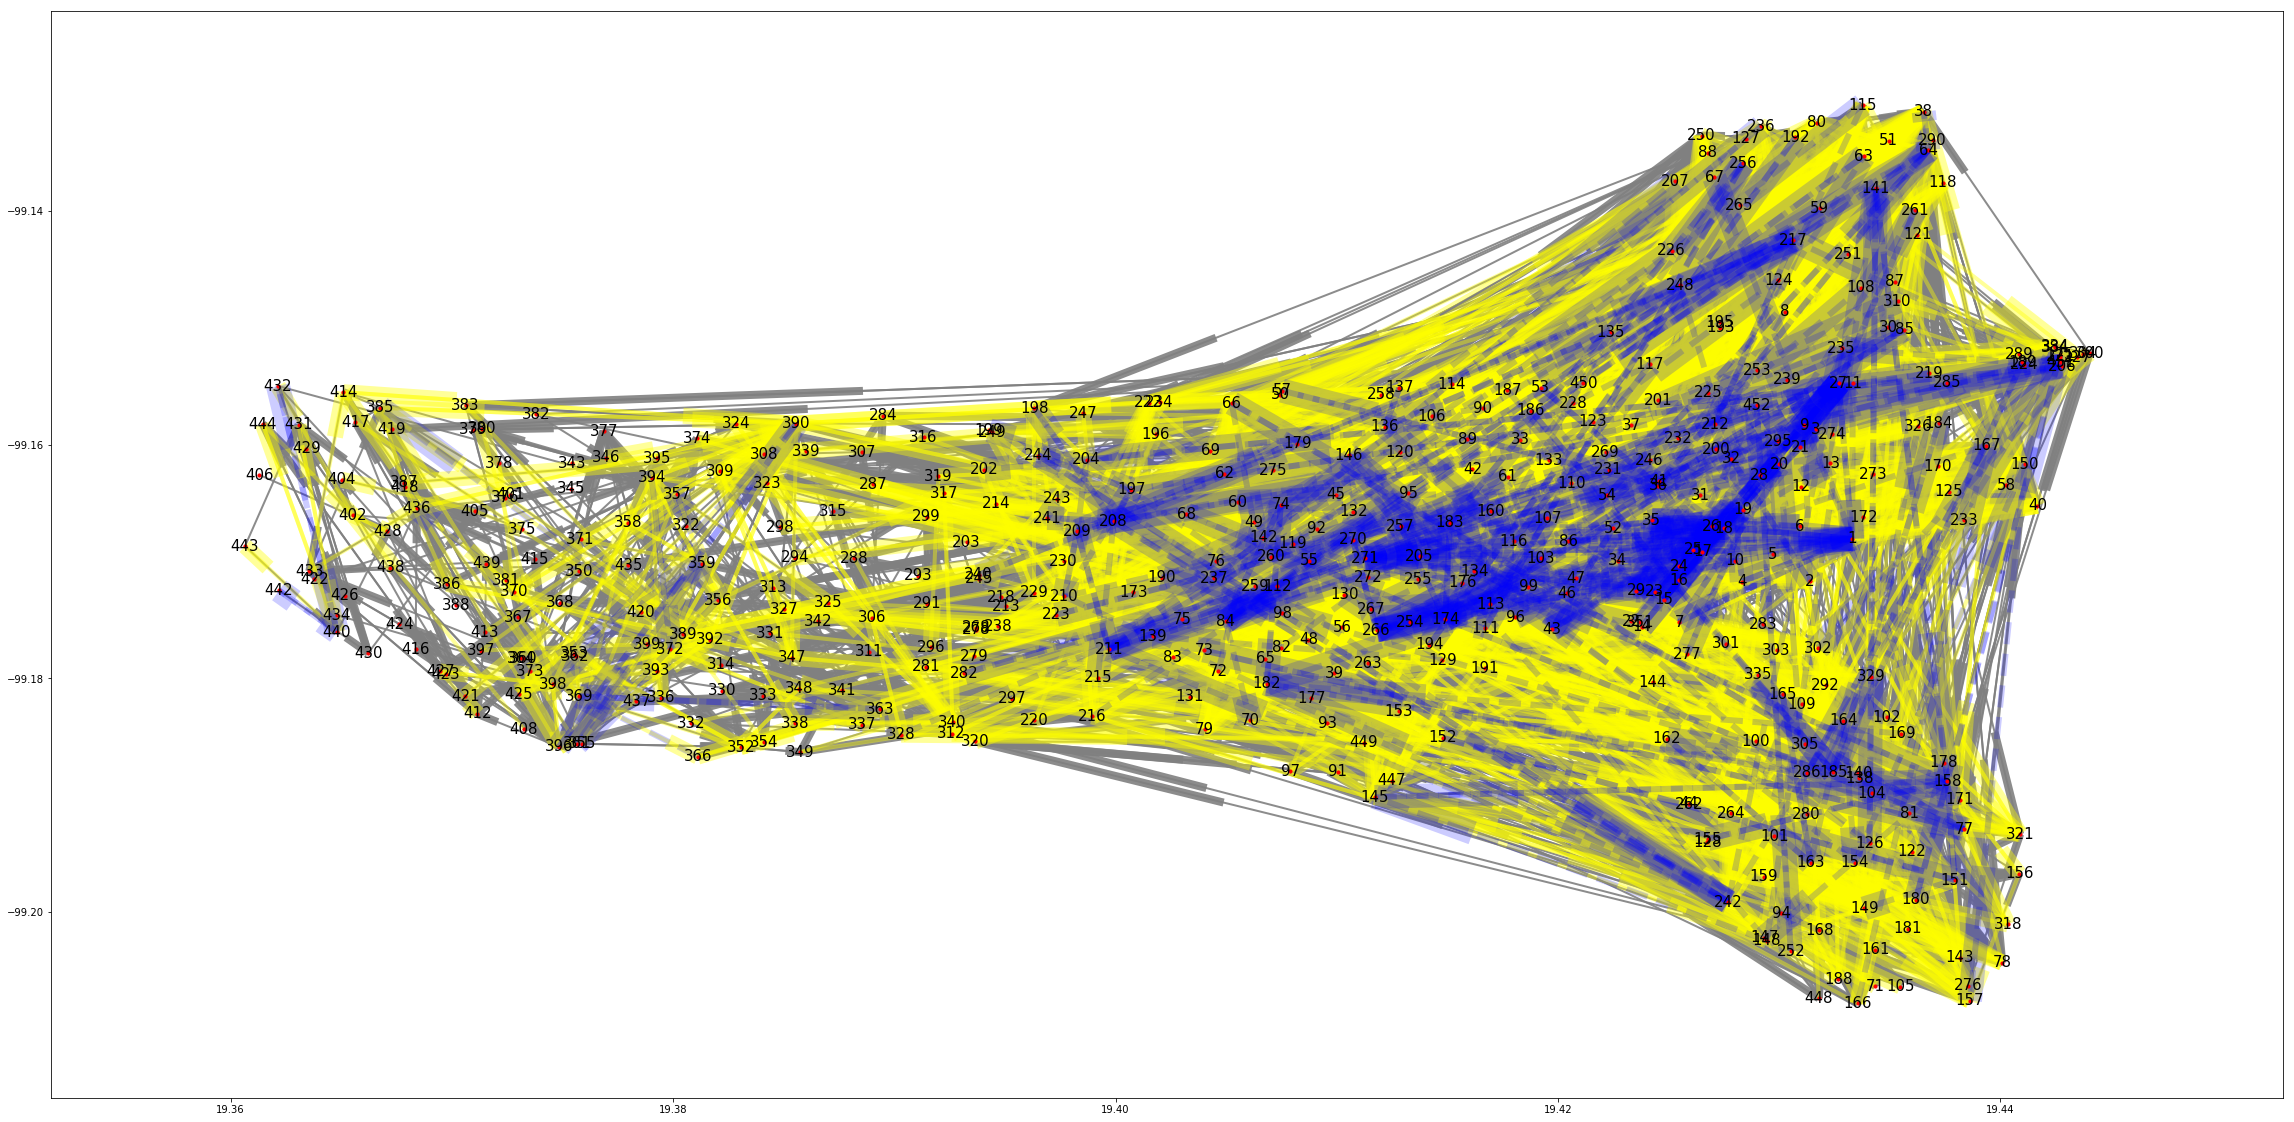

In [221]:
plt.figure(figsize=(40,20))
# nodes
nx.draw_networkx_nodes(G,nx.get_node_attributes(G,'pos'), node_size=10)

# edges
nx.draw_networkx_edges(G,nx.get_node_attributes(G,'pos'), edgelist=smalls,
                       width=2,alpha = 0.9,edge_color='grey')
nx.draw_networkx_edges(G,nx.get_node_attributes(G,'pos'), edgelist=mediums,
                       width=4,alpha = 0.4,edge_color='yellow')
nx.draw_networkx_edges(G,nx.get_node_attributes(G,'pos'), edgelist=larges,
                       width=6, alpha=0.2, edge_color='blue', style='dashed')
nx.draw_networkx_labels(G,nx.get_node_attributes(G,'pos'), font_size=15, font_family='sans-serif');

## Clima

In [3]:
import seaborn as sns

In [4]:
info = pd.read_csv('data/info.csv')

In [5]:
info['RHbins'] = np.trunc( info['value.RH']/10)
info['TMPbins'] = np.trunc(info['value.TMP']/3)
info['WSbins'] = np.trunc(info['value.WSP']/0.5)
info['WSbins'][info['WSbins']==7]=6 #Juntamos el último y penúltimo grupo en WS
info.drop('Unnamed: 0',axis=1,inplace=True) # Eliminamos columnas innecesarias
info.tail()

C:\Users\Scastaneda01\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


year  month  wday  day  hour  Ciclo_Estacion_Retiro  N id_station  \
1158383  2016     12     6   30    23                    111  2        HGM   
1158384  2016     12     6   30    23                     80  1        HGM   
1158385  2016     12     6   30    23                    334  1        MGH   
1158386  2016     12     6   30    23                    116  1        HGM   
1158387  2016     12     6   30     0                    160  1        HGM   

         value.RH  unit.RH  value.TMP  unit.TMP  value.WSP  unit.WSP  RHbins  \
1158383        64        6       14.1         5        0.7         3     6.0   
1158384        64        6       14.1         5        0.7         3     6.0   
1158385        66        6       13.8         5        1.0         3     6.0   
1158386        64        6       14.1         5        0.7         3     6.0   
1158387        66        6       13.8         5        0.3         3     6.0   

         TMPbins  WSbins  
1158383      4.0     1.0  
1158384      4.0     1.0  
1158385      4.0     2.0  
1158386      4.0     1.0  
1158387      4.0     0.0

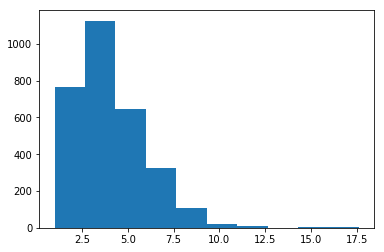

In [6]:
prom_retiros =info.pivot_table(aggfunc=np.mean,index=['year','month','Ciclo_Estacion_Retiro'],values=['N'],).reset_index()
promm_retiros = prom_retiros.pivot_table(aggfunc=np.mean,index='Ciclo_Estacion_Retiro',values=['N'])
plt.hist(prom_retiros['N']);

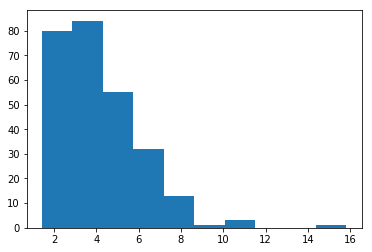

In [7]:
# prom_retiros.sort_values('N',ascending=False)
promm_retiros = prom_retiros.pivot_table(index=['Ciclo_Estacion_Retiro'],values='N',aggfunc=np.mean).sort_values('N',ascending=False)
plt.hist(promm_retiros['N']);

In [8]:
dict_ciclo = promm_retiros.to_dict()
def clasif(ciclo):
    N = dict_ciclo['N'][ciclo]
    if N < 8:
        return 'Bajo'
    elif N < 12:
        return 'Medio'
    else:
        return 'Alto'

In [9]:
info['categoría Cicloestación por uso'] = info['Ciclo_Estacion_Retiro'].map(lambda x: clasif(x))

### Humidity

In [10]:
hum_labels = ['4-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89']

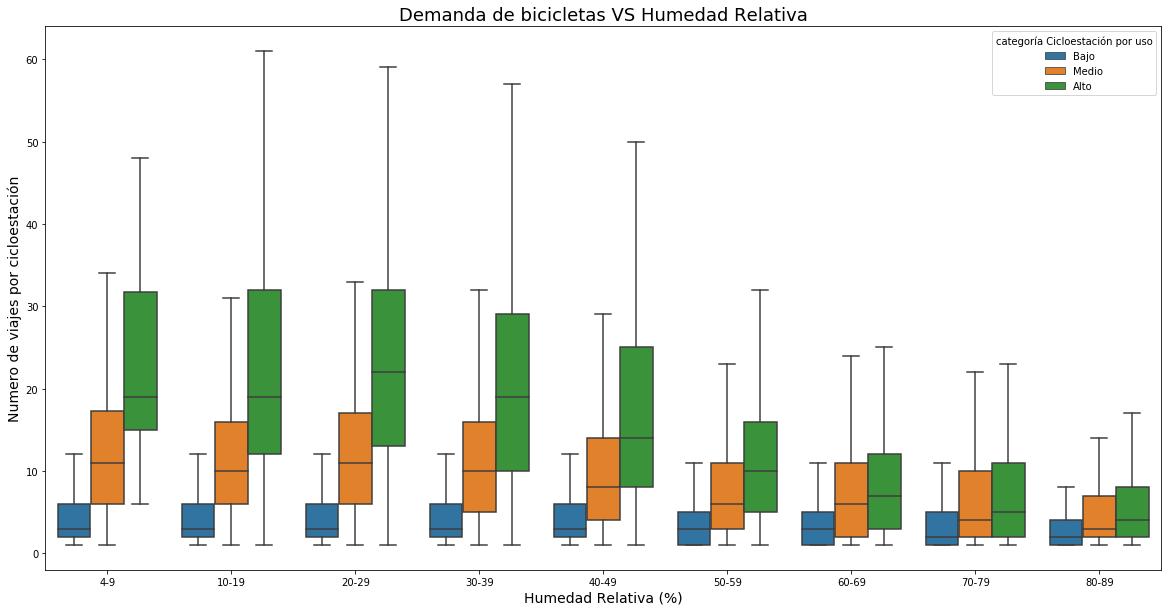

In [18]:
plt.figure(figsize=(20,10))
plt.title('Demanda de bicicletas VS Humedad Relativa',size=18)
sns.boxplot(y='N',x='RHbins',data=info,hue='categoría Cicloestación por uso',showfliers=False)
plt.ylabel('Numero de viajes por cicloestación',size=14)
plt.xlabel('Humedad Relativa (%)',size=14)
plt.xticks(np.arange(0,9),hum_labels);

### Temp

In [12]:
tmp_labels = ['[3-6)','[6-9)','[9-12)','[12-15)','[15-18)','[18-21)','[21-24)','[24-27)','[27-30]']

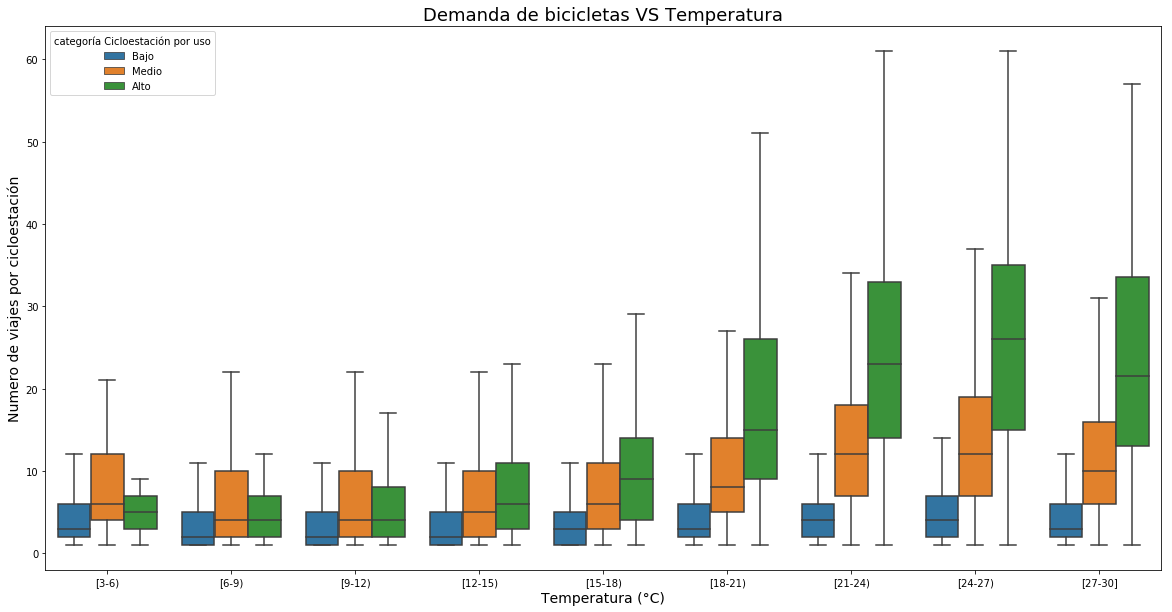

In [17]:
plt.figure(figsize=(20,10))
plt.title('Demanda de bicicletas VS Temperatura',size=18)
sns.boxplot(y='N',x='TMPbins',data=info,hue='categoría Cicloestación por uso',showfliers=False)
plt.ylabel('Numero de viajes por cicloestación',size=14)
plt.xlabel('Temperatura (°C)',size=14)
plt.xticks(np.arange(0,9),tmp_labels);

### Velocidad del Viento

In [14]:
WSlabels = ['[0-0.5)','[0.5-1)','[1-1.5)','[1.5-2)','[2-2.5)','[2.5-3]','[3-4]']

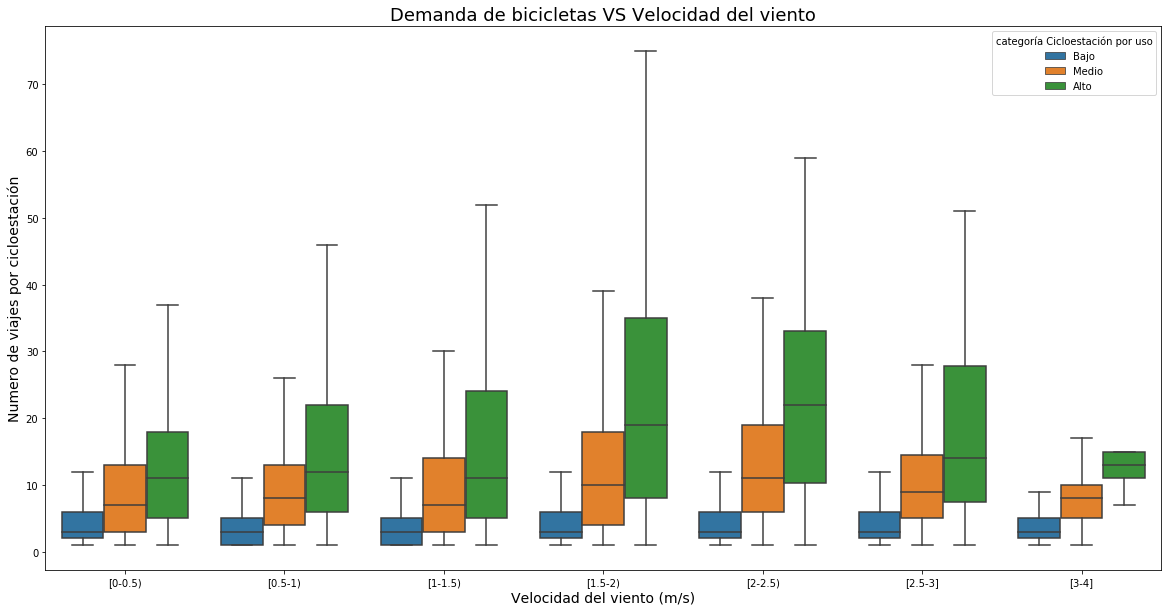

In [19]:
plt.figure(figsize=(20,10))
plt.title('Demanda de bicicletas VS Velocidad del viento',size=18)
sns.boxplot(y='N',x='WSbins',data=info,hue='categoría Cicloestación por uso',showfliers=False)
plt.ylabel('Numero de viajes por cicloestación',size=14)
plt.xlabel('Velocidad del viento (m/s)',size=14)
plt.xticks(np.arange(0,7),WSlabels);